#CGAN with Discriminator as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix,roc_auc_score,average_precision_score
from lightgbm import LGBMClassifier

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

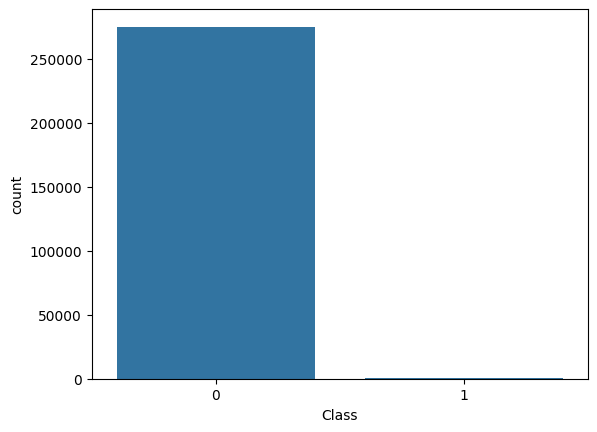

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

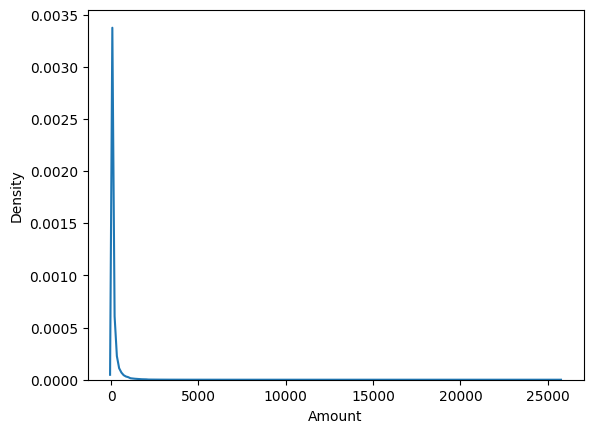

In [ ]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

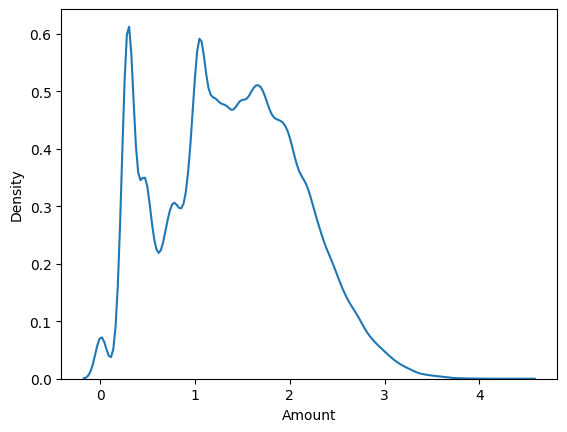

In [ ]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [ ]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are anonymised it was difficult to conclude and get relationship and dependency on eachother.

In [ ]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V16 ↔ V17: r = 0.95
V16 ↔ V18: r = 0.90
V17 ↔ V18: r = 0.93


Reference-https://data36.com/correlation-definition-calculation-corr-pandas/

### TSNE

In [ ]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [ ]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

## Conditional GAN Architecture

In [ ]:
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, multiply, LeakyReLU, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from sklearn.utils import shuffle

class cGAN():
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.num_classes = 2

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=Adam(0.0002, 0.5),
                              metrics=['accuracy'])
        self.combined.summary()

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.3))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.3))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(GaussianNoise(0.1, input_shape=(self.out_shape,)))
        model.add(Dense(256, kernel_initializer=init, kernel_regularizer=l2(0.001)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))
        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model([gen_sample, label], validity, name="Discriminator")

    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # train Discriminator
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size - 8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels], verbose=0)

            valid_smooth = np.random.uniform(low=0.9, high=1.0, size=(batch_size, 1))
            fake_smooth = np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))

            if np.random.rand() < 0.05:
                valid_smooth, fake_smooth = fake_smooth, valid_smooth

            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)


            if (epoch + 1) % sample_interval == 0:
                print(f"{epoch + 1} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] "
                      f"[G loss: {g_loss[0]:.4f}, acc: {100*g_loss[1]:.2f}%]")

                d_real_pred = self.discriminator.predict([samples[:5], labels[:5]], verbose=0).flatten()
                d_fake_pred = self.discriminator.predict([gen_samples[:5], labels[:5]], verbose=0).flatten()
                print("Disc pred on real:", np.round(d_real_pred, 2))
                print("Disc pred on fake:", np.round(d_fake_pred, 2))

            if (epoch + 1) % 100 == 0:
                self.save_generated_samples(epoch + 1)

    def save_generated_samples(self, epoch):
        noise = np.random.normal(0, 1, (5, self.latent_dim))
        labels = np.array([[0], [1], [0], [1], [1]])
        gen_samples = self.generator.predict([noise, labels])
        print(f"Generated samples at epoch {epoch}:\n{gen_samples}")

In [ ]:
cgan = cGAN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

## Training GAN

In [ ]:
y_train = y_train.reshape(-1, 1)
pos_index = np.where(y_train == 1)[0]
neg_index = np.where(y_train == 0)[0]

cgan.train(X_train, y_train, pos_index, neg_index, epochs=1000)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



50 [D loss: 0.6911, acc: 0.00%] [G loss: 0.6945, acc: 43.00%]
Disc pred on real: [0.5 0.5 0.5 0.5 0.5]
Disc pred on fake: [0.5 0.5 0.5 0.5 0.5]
100 [D loss: 0.6828, acc: 0.00%] [G loss: 0.6921, acc: 47.97%]
Disc pred on real: [0.5  0.49 0.5  0.5  0.5 ]
Disc pred on fake: [0.48 0.48 0.48 0.48 0.48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Generated samples at epoch 100:
[[-5.1834011e-01 -2.0382386e-01  9.8843002e-01 -2.6274100e-01
   9.9122959e-01  9.4451684e-01 -9.6761990e-01  1.7531461e-01
  -4.9957028e-01  9.9470133e-01 -9.9982876e-01  9.9897265e-01
  -4.1929147e-01  9.9904829e-01  8.0415893e-01  8.4356201e-01
  -5.9818067e-02  7.6722443e-01 -4.4737509e-01  4.5625758e-01
  -2.7136129e-01  4.7387588e-01 -6.1011285e-01  5.6582481e-01
   1.6963549e-01 -9.4430679e-01  9.7348630e-01 -6.7981285e-01
   8.7628812e-02]
 [-8.5352731e-01 -8.8779837e-01  5.0870299e-01 -7.3818225e-01
   6.2656152e-01 -9.8554021e-01 -9.8830599e-01  8.7247652e-01
  -9.4945627e-01 -9.4942594e-01  9.2501187e-01 -9.42870

## Generating new samples

In [ ]:
noise = np.random.normal(0, 1, (250000, 32))
sampled_labels = np.ones(250000).reshape(-1, 1) #ones in order to only fraud data

gen_samples = cgan.generator.predict([noise, sampled_labels])
gen_samples = scaler.inverse_transform(gen_samples)
print(gen_samples.shape)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 126s 16ms/step
(250000, 29)


In [ ]:
gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('Class',axis=1).columns)
gen_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.382748,-0.920994,1.437713,1.142813,-1.370926,0.676446,-1.053056,-0.799872,-1.102475,-1.082865,...,0.273542,0.727202,-0.180391,0.622315,0.544759,0.337829,0.478707,-0.373926,0.207678,2.022501
1,0.766757,0.190086,0.654460,1.403139,-1.359686,1.121842,0.823618,-1.148636,-0.882165,-1.082174,...,0.651677,0.697798,0.539523,0.480469,-0.143268,0.395480,0.459185,-0.395421,0.288562,1.989642
2,-1.988948,1.572716,-1.482015,1.413014,-1.382037,-1.284267,-1.231538,-1.146650,-1.101146,-1.083749,...,-0.297546,0.261854,0.616736,0.520884,-0.421070,-0.288528,-0.384583,-0.396893,-0.228749,0.801918
3,-1.945275,0.137525,-1.480536,1.419802,-1.385432,-0.868818,-1.114482,-1.153002,-1.105985,-1.083721,...,-0.743040,0.735155,0.701531,0.615823,0.595798,-0.524550,-0.482958,-0.201518,0.279568,0.907155
4,-1.428612,1.442521,1.480904,1.395652,-1.024183,0.159610,-0.686662,-1.090681,-1.069508,-1.072652,...,0.520806,0.717950,0.697703,0.369577,-0.087448,-0.184120,0.367561,-0.347412,0.008444,2.078140


In [ ]:
gen_X_train = np.concatenate((X_train, gen_samples), axis=0)
gen_X_train.shape

(470530, 29)

In [ ]:
gen_y = np.ones((250000, 1))
gen_y_train = np.concatenate((y_train, gen_y), axis=0)
gen_y_train.shape

(470530, 1)

## Testing baseline model with generated data

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_1                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 110s 66ms/step - accuracy: 0.9956 - loss: 0.2094 - val_accuracy: 1.0000 - val_loss: 7.0874e-04
Epoch 2/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 141s 66ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 2.1158e-04
Epoch 3/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 143s 67ms/step - accuracy: 1.0000 - loss: 5.3219e-04 - val_accuracy: 1.0000 - val_loss: 9.3154e-05
Epoch 4/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 140s 66ms/step - accuracy: 1.0000 - loss: 1.6818e-04 - val_accuracy: 1.0000 - val_loss: 4.1670e-05
Epoch 5/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 146s 68ms/step - accuracy: 1.0000 - loss: 5.9584e-05 - val_accuracy: 1.0000 - val_loss: 1.7771e-05
Epoch 6/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 136s 64ms/step - accuracy: 1.0000 - loss: 2.1861e-05 - val_accuracy: 1.0000 - val_loss: 7.0624e-06
Epoch 7/50
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 144s 65ms/step - accuracy: 1.0000 - loss: 8.1769e-06 - val_accuracy: 1.0000 - val_loss: 2.7003e-06
Epoch 8/50
1655/1655 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



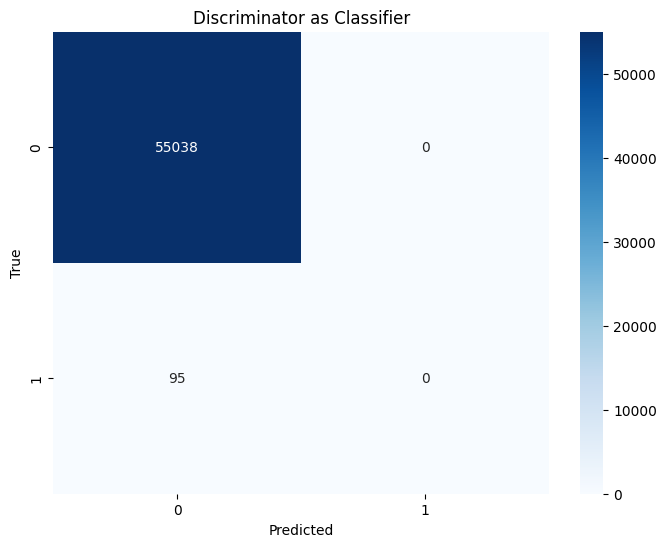

In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# re-compile a fresh discriminator
disc = cgan.build_discriminator()
disc.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# fit on your augmented data: X and its true label as the “conditioning”
disc.fit(
    x=[gen_X_train, gen_y_train],
    y=np.ones((gen_X_train.shape[0],1)),
    epochs=50,
    batch_size=256,
    validation_split=0.1
)


n_test = X_test.shape[0]
zeros = np.zeros((n_test,1), dtype=int)
ones  = np.ones((n_test,1),  dtype=int)


p0 = disc.predict([X_test, zeros], batch_size=256).ravel()
p1 = disc.predict([X_test, ones],  batch_size=256).ravel()


y_pred = (p1 > p0).astype(int)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Discriminator as Classifier")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_prob)
pr  = average_precision_score(y_test, y_prob)

print(f"\nROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr:.4f}\n")
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




ROC-AUC: 0.6989
PR-AUC:  0.2222



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



              precision    recall  f1-score   support

           0     0.9993    0.9973    0.9983     55038
           1     0.2843    0.6105    0.3880        95

    accuracy                         0.9967     55133
   macro avg     0.6418    0.8039    0.6931     55133
weighted avg     0.9981    0.9967    0.9973     55133

ROC AUC: 0.8039368015591143


The raw discriminator is not suitable as a classifier → it collapsed into predicting only the majority class.

However, its feature representations contain useful anomaly signals. Passing them into LightGBM gives decent recall (61%) with a big improvement in ROC-AUC/PR-AUC compared to raw use.

This suggests the discriminator should not be used directly, but as a feature extractor feeding supervised models.

Discriminator-alone: not viable for classification.

Discriminator embeddings + supervised learner: promising, but still weaker than the specialized GAN-RNN/LSTM models and even autoencoder.

Best strategy: treat discriminator outputs as features, not final predictions.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), https://github.com/vishk23/CreditCardFraudDetectionGAN

Note- ChatGPT used for understanding results and how discriminator can be used.


